# Best neigborhood in pgh based on parking #

Matt's data: Parking lot spots and rates by zone

## Initial code ##

In [2]:
import pandas as pd
import geopandas
from shapely.geometry import Point

# Load neighborhoods
NEIGHBORHOODS = geopandas.read_file("https://data.wprdc.org/dataset/e672f13d-71c4-4a66-8f38-710e75ed80a4/resource/c5a93a8e-03d7-4eb3-91a8-c6b7db0fa261/download/pittsburghpaneighborhoods-.zip")
# Load zip codes
ZIPS = geopandas.read_file("https://data.wprdc.org/dataset/1a5135de-cabe-4e23-b5e4-b2b8dd733817/resource/ec228c0e-6b1e-4f44-a335-df05546d52ea/download/alcogisallegheny-county-zip-code-boundaries.zip")

#load data from csv
lotData = pd.read_csv("Space_count_and_rate.csv",index_col="_id")
meterData = pd.read_csv("Meter_data.csv",index_col="_id")

In [3]:
#functions from snippets
def geo_to_neighborhood(latitude, longitude):
    """Converts a geolocation (latitude and longitude) to a Pittsburgh neighborhood name.

    Args:
        latitude (float): The latitude of the point.
        longitude (float): The longitude of the point.

    Returns:
        Union[str, None]: Name of the Pittsburgh neighborhood the point falls within or None if it does not fall within a neighborhood.
    """
    # Create a shapely point for the latitude and longitude
    pt = Point(longitude, latitude)
    # Loop through the neighborhoods
    for _idx, neighborhood in NEIGHBORHOODS.iterrows():
        # Check if this neighborhood contains the point
        if neighborhood["geometry"].contains(pt):
            # Return the name of the neighborhood
            return neighborhood["hood"]
    # Wasn't contained in the neighborhood
    return None

This CSV has the names, space count, and hourly rate of parking lots in pittsburgh. Data can be found/downloaded here: https://data.wprdc.org/dataset/zone-and-lot-attributes

TODO: Separate data by neighborhood.

Possible need: translate zone to neighborhood with secondary dataset
Use lat/long from meters set w/ code snippets to get neighborhoods of various zones

Get the following data: 

num lots, tot spaces, avg num spaces per lot, avg rate, max/min rate (done-ish)

separate data by on and off street parking, then assume one meter per lot and re-work data from there

provide analysis+metrics for "best" ex: Easiest to park in (most lots/spaces) cheapest to park in, then combine these metrics to find the best 

In [4]:
#Data not separated by neighborhood
lotData.head(5)

,zone,as_of,spaces,rate,rate_description,meters,type
_id,,,,,,,
1,301 - Sheridan Harvard Lot,2017-03-06,41,1.0,$1.00/HR,2.0,off-street
2,302 - Sheridan Kirkwood Lot,2017-03-06,114,1.0,$1.00/HR,3.0,off-street
3,304 - Tamello Beatty Lot,2017-03-06,76,1.0,$1.00/HR,2.0,off-street
4,307 - Eva Beatty Lot,2017-03-06,130,1.0,$1.00/HR,2.0,off-street
5,311 - Ansley Beatty Lot,2017-03-06,23,1.0,$1.00/HR,1.0,off-street


In [5]:
#avg spaces overall
AvgAllSpc = lotData["spaces"].mean()
#avg rate overall
AvgAllRt = lotData["rate"].mean()

print("Avgerage number of spaces (to nearest whole space): %.0f" % (AvgAllSpc))
print("Average hourly rate: $%.2f" % (AvgAllRt))

Avgerage number of spaces (to nearest whole space): 170
Average hourly rate: $1.36


In [6]:
#ppa zones to neighborhoods
zToN = {}

for zone in lotData['zone']:
    i=1
    for meter in meterData['zone']:
        if meter == zone:
            try:
                lat=float(meterData.iat[i,3])
                lon=float(meterData.iat[i,4])
            except:
                pass
            #print(lat,lon,geo_to_neighborhood(lat,lon))
            zToN[zone] = geo_to_neighborhood(lat,lon)
        i+=1
print('done')


done


In [9]:
#find number of spaces per neighborhood and lots per neighborhood
spacesPerN = {}
lotsPerN = {}
#dict of lists for rates per neighborhood
ratesPerN = {}
#calcd with dict of lists
avgRatePerN = {}
maxPerN = {}
minPerN = {}

for hood in zToN:
    for index, row in lotData.loc[:,['zone','spaces','rate']].iterrows():
        if hood == row['zone']:
            if hood in spacesPerN.keys():
                spacesPerN[zToN[hood]]+=row['spaces']
                lotsPerN[zToN[hood]]+=1
                ratesPerN[zToN[hood]].append(row['rate'])
            else:
                spacesPerN[zToN[hood]]=row['spaces']
                lotsPerN[zToN[hood]]=1
                ratesPerN[zToN[hood]] = [row['rate']]

#calc min max and avg
for hood in ratesPerN:
    ratesPerN[hood].sort()
    minPerN[hood] = ratesPerN[hood][0]
    ratesPerN[hood].reverse()
    maxPerN[hood] = ratesPerN[hood][0]
    hoodTot=0
    for vals in ratesPerN[hood]:
        hoodTot+=vals
    avgRatePerN[hood] = vals/lotsPerN[hood]
    
print('done')    

done


## Data and Graphs ##

In [10]:
#Creating dataframes for plotting
lotDataDict = {}
count = 5
hoods = []
for hood in spacesPerN:
    lotDataDict[hood] = [spacesPerN[hood],lotsPerN[hood],avgRatePerN[hood],minPerN[hood],maxPerN[hood]]
    hoods.append(hoods)
lotDataFrame = pd.DataFrame(lotDataDict, index=['spaces','lots','avg rate','min rate','max rate'])
lotDataFrame.head(5)

,Squirrel Hill South,Bluff,None,South Side Flats,Bloomfield,South Oakland,Allegheny Center,Central Business District,Shadyside,Strip District,...,North Shore,Crawford-Roberts,East Liberty,Beechview,North Oakland,Central Lawrenceville,Central Northside,East Allegheny,Brookline,Carrick
spaces,201.0,29.0,78.0,98.0,48.0,69.0,428.0,476.0,27.0,24.0,...,45.0,13.0,757.0,299.0,572.0,483.0,354.0,707.0,237.0,52.0
lots,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
avg rate,1.0,1.0,1.0,1.0,NaN,1.0,1.5,3.0,1.0,1.0,...,2.0,1.0,1.0,4.0,3.0,1.5,1.5,1.5,3.0,1.0
min rate,1.0,1.0,1.0,1.0,NaN,1.0,1.5,3.0,1.0,1.0,...,2.0,1.0,1.0,4.0,3.0,1.5,1.5,1.5,3.0,1.0
max rate,1.0,1.0,1.0,1.0,NaN,1.0,1.5,3.0,1.0,1.0,...,2.0,1.0,1.0,4.0,3.0,1.5,1.5,1.5,3.0,1.0


### Parking Spots Per Neighborhood ###

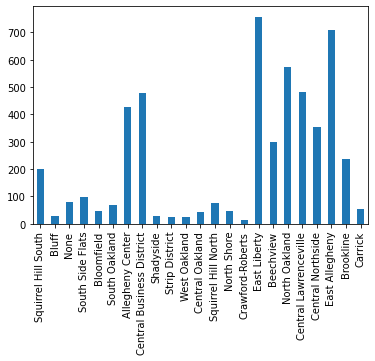

In [11]:
#plotting
lotDataFrame.loc['spaces'].plot.bar()

### Average Rate Per Neighborhood ###

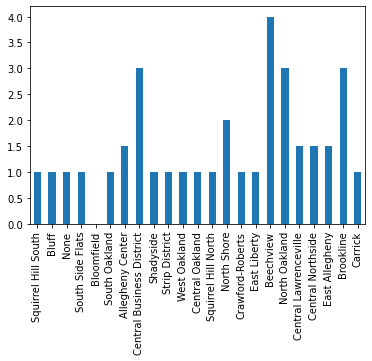

In [12]:
lotDataFrame.loc['avg rate'].plot.bar()

### Minimum Rate Per Neighborhood ###

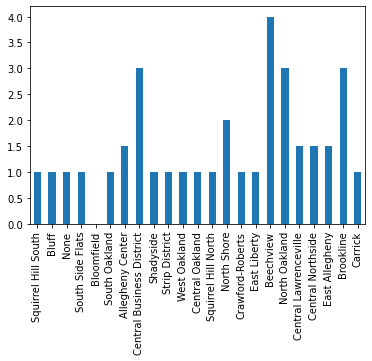

In [13]:
lotDataFrame.loc['min rate'].plot.bar()

### Maximum Rate Per Neighborhood ###

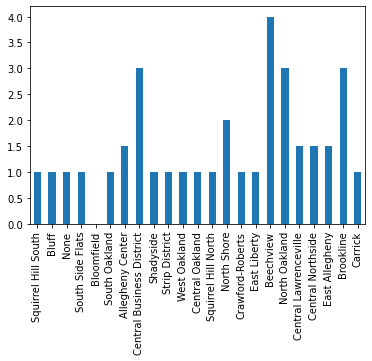

In [14]:
lotDataFrame.loc['max rate'].plot.bar()

### Graph of Variance ###

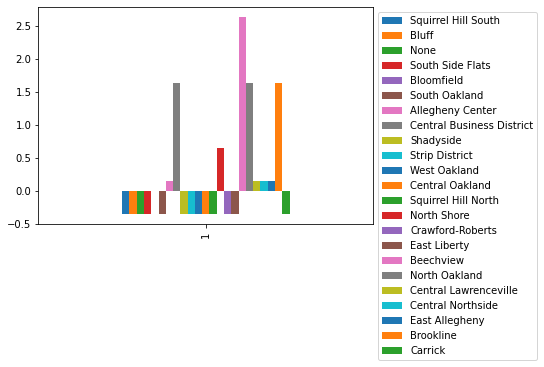

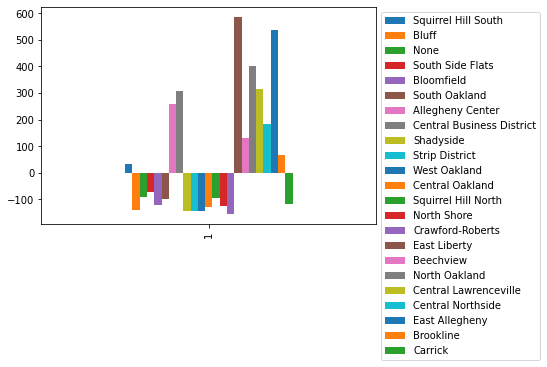

In [26]:
# graph showing distance from average of all neighborhoods
varRate = {}
varSpc = {}
for hood in spacesPerN:
    varRate[hood] = lotDataFrame.at['avg rate',hood] - AvgAllRt
    varSpc[hood] = lotDataFrame.at['spaces',hood] - AvgAllSpc

# turning the varDicts into a df
varRateDF = pd.DataFrame(varRate, index=[1])
varSpcDF = pd.DataFrame(varSpc, index=[1])
varRateDF.plot.bar().legend(bbox_to_anchor=(1.0, 1.0))
varSpcDF.plot.bar().legend(bbox_to_anchor=(1.0, 1.0))

## Conclusions ##

The data apparently already was by neighborhood, just turned into zones for some reason. This makes the min, max, and average per neighborhood irrelevant. As such, each neighborhood will be compared to the average of all rates and average number of spaces.

As was shown earlier, the average number of spaces in a neighborhood, rounded to the nearest whoel space, is 170. The average rate is \\$1.36/hr. For cheapest neighborhood to park in, there is a 13 way tie at \\$1 per hour. However, when we look at the number of spaces we see that, with the exception of two neighborhoods, most of these below average priced neighborhoods have below average number of spaces. When we look at these exceptions, we can find what I would argue to be the best neighborhood to park in based on this data. With the most available parking spots, and tied for the lowest rate: South Oakland is our winner. Now this doesn't account for popularity of the neighborhood in terms of parking. That is in another dataset. But based on the the hourly rate and number of spaces available, the best neighborhood to park in Pittsburgh is South Oakland.